**QR Generator With Stable Diffusion**

In [3]:
!pip -q install diffusers torch xformers qrcode accelerate transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 7.8 MB/s eta 0:00:00


QR Code Generator

In [4]:
import qrcode
from PIL import Image

In [5]:
class QrCodeGenerator():
  def __init__(self):
    self.qr = qrcode.QRCode(
        version = 1,
        error_correction=qrcode.constants.ERROR_CORRECT_H,
        box_size= 16,
        border = 0,
    )

  def generate_qr_code(self, qrcode_content: str):
     self.qr.add_data(qrcode_content)
     self.qr.make(fit=True)

     img = self.qr.make_image(fill_color="black", back_color="white")
     return img.get_image()

  def add_offset_bg(self, img: Image, offset_min: int = 0):
    w, h = img.size
    w = (w + 255 + offset_min)
    h = (h + 255 + offset_min)

    if w > 1024:
      raise ValueError("WR Code is too big, please re-generate a shorter URL")
    bg_img = Image.new('L', (w,h), 255)
    coords = ((w-img.size[0]) // 2 // 16*16,
              (h-img.size[1]) // 2 // 16*16)
    bg_img.paste(img, coords)
    return bg_img

In [6]:
qrcode_gen = QrCodeGenerator()
qrcode_img = qrcode_gen.generate_qr_code("https://dandev947366.github.io/")

bg_qrcode_img = qrcode_gen.add_offset_bg(qrcode_img)


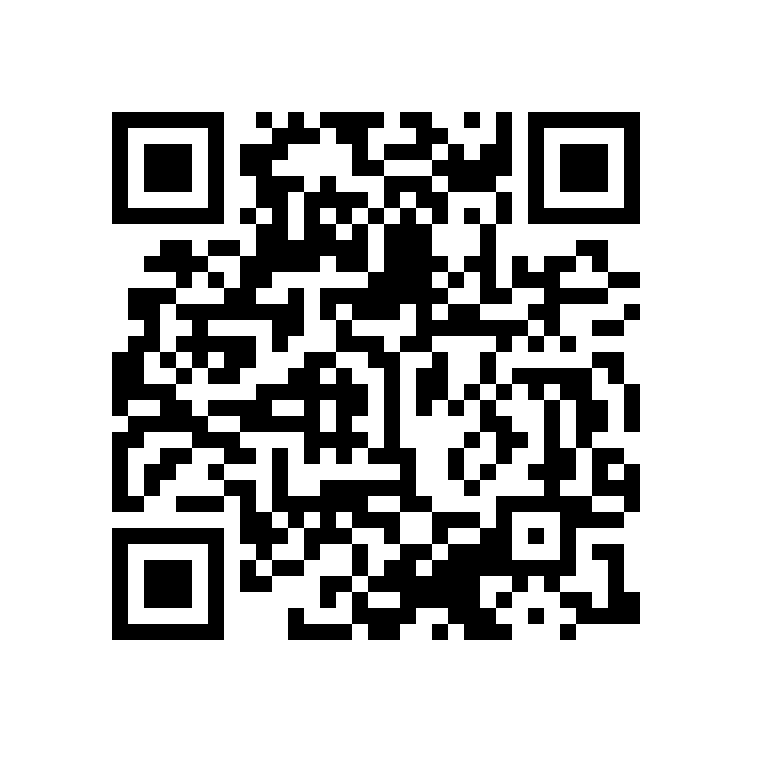

In [7]:
bg_qrcode_img

**QR Code Conditioned ControlNet Models For Stable Diffusion 1.5**




In [8]:
# load ControlNet Pre-train
from diffusers import ControlNetModel, StableDiffusionControlNetImg2ImgPipeline, DDIMScheduler
import torch
from typing import Tuple
from diffusers.utils import load_image

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [9]:
controlnet = ControlNetModel.from_pretrained(
    "DionTimmer/controlnet_qrcode-control_v1p_sd15",
    torch_dtype=torch.float16
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/954 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

In [11]:
# Load the pipeline with ControlNet
cn_pipeline = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16,
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [12]:
cn_pipeline.enable_xformers_memory_efficient_attention()
cn_pipeline.scheduler = DDIMScheduler.from_config(cn_pipeline.scheduler.config)
cn_pipeline.enable_model_cpu_offload()

In [13]:
IMG_WIDTH, IMG_HEIGHT = 768, 768

def resize_image(input_image: Image, resolution: Tuple[int, int] = (IMG_WIDTH, IMG_HEIGHT)) -> Image:
    input_image = input_image.convert("RGB")  # Correct use of the convert method
    img = input_image.resize(resolution, resample=Image.LANCZOS)
    return img


In [16]:
# QR Image
condition_img = resize_image(bg_qrcode_img)
# Init Image: any img
input_image = Image.open("./helsinki.jpeg")
init_img = resize_image(input_image)


# New Section

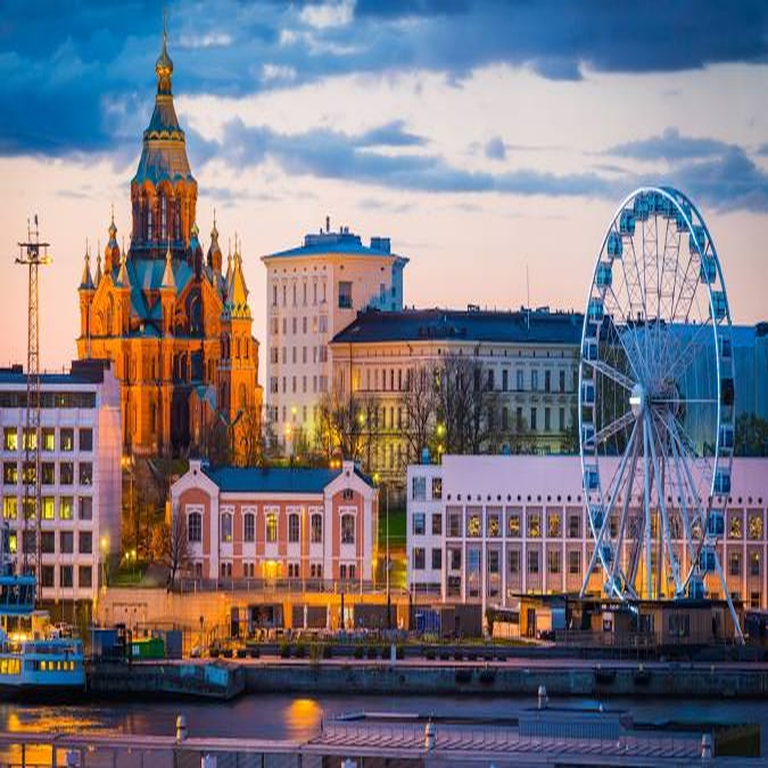

In [17]:
init_img

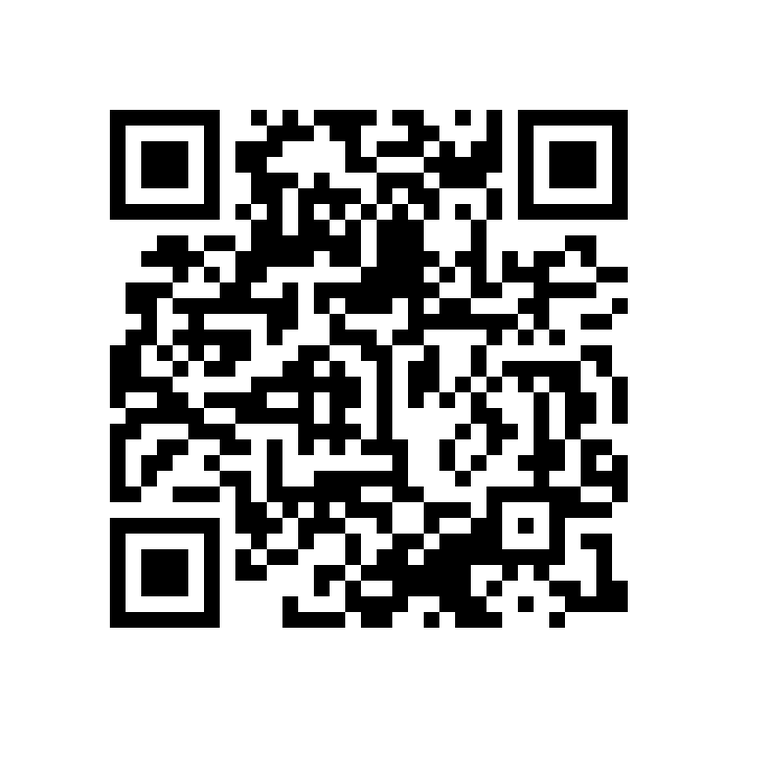

In [18]:
condition_img

In [19]:
init_img, condition_img

(<PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>)

In [20]:
generator = torch.Generator()

  0%|          | 0/32 [00:00<?, ?it/s]

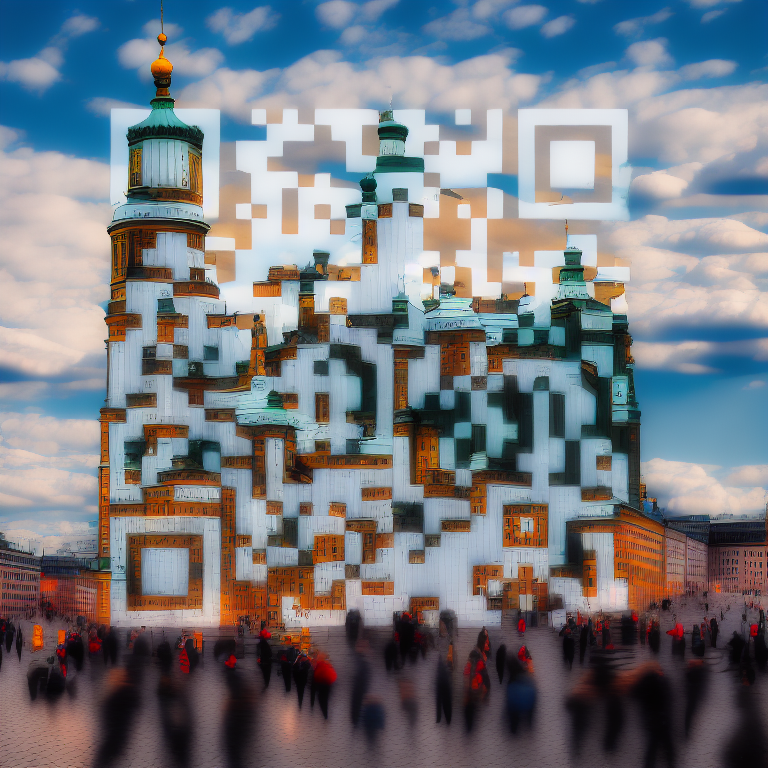

In [27]:
output = cn_pipeline(
    prompt="Helsinki, Finland",
    negative_prompt="blurry, low quality",
    image=init_img,
    control_image=condition_img,
    width=IMG_WIDTH,
    height=IMG_HEIGHT,
    guidance_scale=7.5,
    controlnet_conditioning_scale=2.1,
    generator=generator,
    streght=0.9,
    num_inference_steps=40
)

output.images[0]